# HOMEWORK 3

##IMPORTS

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.model_selection import ParameterGrid

##PROBLEM 1.1

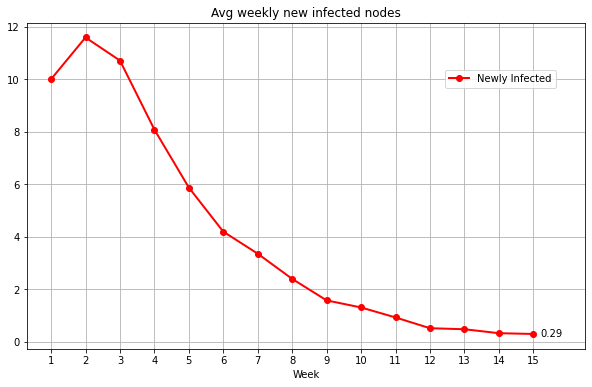

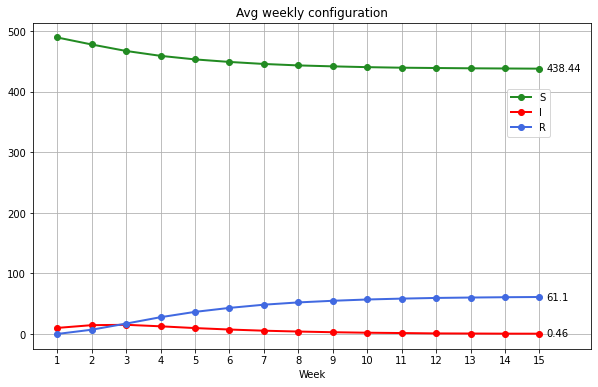

In [ ]:
# PARAMETERS
n = 500
k = 4
beta = 0.3  # Infection probability
rho = 0.7  # Recovery probability
n_weeks = 15
n_initial_infected = 10
n_iter = 100

new_infected_over_time = np.zeros(n_weeks, dtype=int)
susceptible_over_time = np.zeros(n_weeks, dtype=int)
infected_over_time = np.zeros(n_weeks, dtype=int)
recovered_over_time = np.zeros(n_weeks, dtype=int)

# GRAPH CONSTRUCTION
neighs = [int(i-(k/2)) for i in range(0, k+1) if i!=k/2]
W = np.zeros((n, n), dtype=int)

for neigh in neighs:
  W = W + np.diag(np.ones((n-abs(neigh)), dtype=int), neigh) + np.diag(np.ones((abs(neigh)), dtype=int), int(n*(abs(neigh)/neigh))-neigh)

if n < 32:
  G = nx.from_numpy_matrix(W)
  plt.figure(1,figsize=(n,n))
  nx.draw_spectral(G, with_labels=True)

# SIMULATION
for iter in range(0,n_iter):
  
  # Selecting n_initial_infected
  x0 = np.zeros(n, dtype=int)  # initial configuration
  initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
  for infected in initial_infected:
    x0[infected] = 1
  states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

  susceptible_over_time[0] += n - n_initial_infected
  infected_over_time[0] += n_initial_infected
  recovered_over_time[0] += 0
  new_infected_over_time[0] += n_initial_infected

  for week in range(1,n_weeks):
    last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
    current_week_config = np.zeros(n, dtype=int)
    new_infected_cnt = 0
    
    for node in range(0, n):

      if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
        m = np.count_nonzero(np.multiply(W[node], last_week_config) == 1.0)
        current_week_config[node] = np.random.choice([0, 1], p=[(1-beta)**m, 1-((1-beta)**m)])
        if current_week_config[node] == 1:
          new_infected_cnt += 1

      elif last_week_config[node] == 1:  # compute recovery probability
        current_week_config[node] = np.random.choice([1, 2], p=[1-rho, rho])

      else:  # stays recovered
        current_week_config[node] = 2

    states = sp.sparse.vstack([states,current_week_config])
          
    # Counts for visualizations
    susceptible_over_time[week] += np.count_nonzero(current_week_config == 0)
    infected_over_time[week] += np.count_nonzero(current_week_config == 1)
    recovered_over_time[week] += np.count_nonzero(current_week_config == 2)
    new_infected_over_time[week] += new_infected_cnt

avg_susceptible_over_time = susceptible_over_time / n_iter
avg_infected_over_time = infected_over_time / n_iter
avg_recovered_over_time = recovered_over_time / n_iter
avg_new_infected_over_time = new_infected_over_time / n_iter

time = [i for i in range(1,n_weeks+1)]
fig_1, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_new_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='Newly Infected')
ax.legend(loc=(0.75, 0.8))
ax.set_xlabel('Week')
ax.set_title('Avg weekly new infected nodes')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_new_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-0.1, str(y), color='k')
plt.show()

fig_2, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_susceptible_over_time, c='forestgreen', marker='o', linestyle='-', linewidth=2, label='S')
ax.plot(time, avg_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='I')
ax.plot(time, avg_recovered_over_time, c='royalblue', marker='o', linestyle='-', linewidth=2, label='R')
ax.legend(loc=(0.85, 0.65))
ax.set_xlabel('Week')
ax.set_title('Avg weekly configuration')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_susceptible_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_recovered_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
plt.show()

if n < 32:
  # Plot the infection spread
  pos = nx.spectral_layout(G)
  fig = plt.figure(figsize=(20,20))
  for t in range(0,n_weeks):
      plt.subplot(3,5,t+1)
      x = np.array(states.tocsr()[t].toarray()[0], dtype=int)
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==0).T[0].tolist(),
          node_color = 'forestgreen')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==1).T[0].tolist(),
          node_color = 'red')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==2).T[0].tolist(),
          node_color = 'royalblue')
      plt.title('Week = {0}'.format(t+1))

##PROBLEM 1.2

In [ ]:
def Generate_PA_Graph(total_nodes, avg_degree, a):

  GPA = nx.complete_graph(avg_degree + 1)  # starting complete graph
  residual = 0

  while len(GPA) < total_nodes:
    node = len(GPA)

    if avg_degree % 2 == 0:
      node_degree = avg_degree // 2
    else:
      node_degree = avg_degree // 2 + residual
      residual = (avg_degree % 2 + residual) % 2  # in order to alternate adding one more and one less if k odd

    deg_PA = np.array([d for n, d in GPA.degree()]) + a
    probabilities = deg_PA/sum(deg_PA)  # normalization to obtain a probability distribution
    neighs = np.random.choice(np.arange(len(GPA)), p=probabilities, size=node_degree, replace=False)
      
    GPA.add_node(node)  # Node insertion
    for neigh in neighs:
      GPA.add_edge(node,neigh)  # Edges creation

  return GPA

NUMBER OF NODES: 8
NODES DEGREES: [4, 3, 5, 5, 1, 2, 2, 2]
AVG DEGREE: 3.0


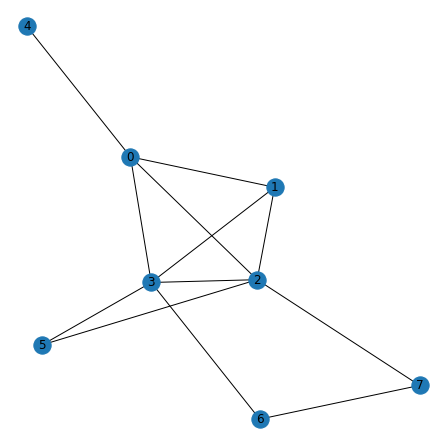

In [ ]:
G = Generate_PA_Graph(8, 3, 0)
W = nx.adjacency_matrix(G)
# print(W.todense())
plt.figure(1,figsize=(6,6))
nx.draw(G, with_labels=True)
degrees = [d for n, d in G.degree()]

print("NUMBER OF NODES:", len(G))
print("NODES DEGREES:", degrees)
print("AVG DEGREE:", sum(degrees)/len(degrees))

##PROBLEM 2

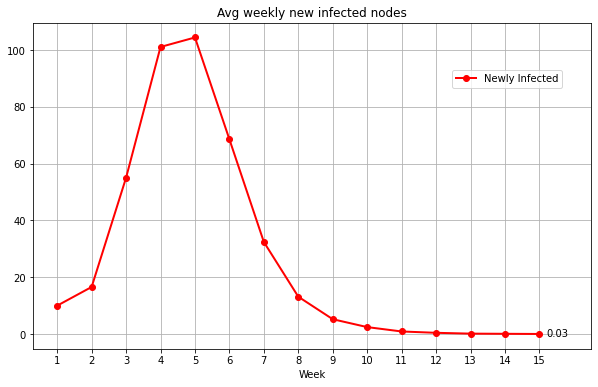

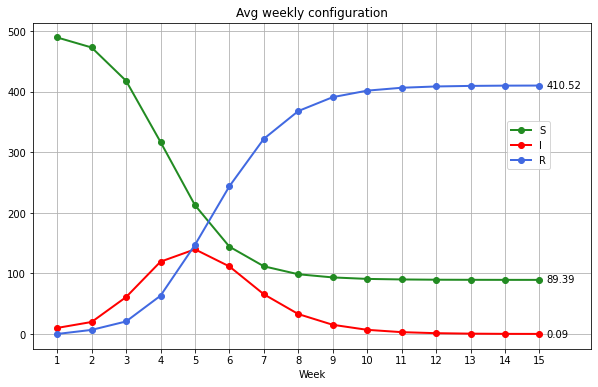

In [ ]:
# PARAMETERS
n = 500
k = 6
a = 0
beta = 0.3  # Infection probability
rho = 0.7  # Recovery probability
n_weeks = 15
n_initial_infected = 10
n_iter = 100

new_infected_over_time = np.zeros(n_weeks, dtype=int)
susceptible_over_time = np.zeros(n_weeks, dtype=int)
infected_over_time = np.zeros(n_weeks, dtype=int)
recovered_over_time = np.zeros(n_weeks, dtype=int)

# GRAPH CONSTRUCTION
G = Generate_PA_Graph(n, k, a)
W = nx.adjacency_matrix(G)

if n < 32:
  plt.figure(1,figsize=(6,6))
  nx.draw(G, with_labels=True)

# SIMULATION
for iter in range(0,n_iter):

  # Selecting n_initial_infected
  x0 = np.zeros(n, dtype=int)  # initial configuration
  initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
  for infected in initial_infected:
    x0[infected] = 1
  states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

  susceptible_over_time[0] += n - n_initial_infected
  infected_over_time[0] += n_initial_infected
  recovered_over_time[0] += 0
  new_infected_over_time[0] += n_initial_infected

  for week in range(1,n_weeks):
    last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
    current_week_config = np.zeros(n, dtype=int)
    new_infected_cnt = 0
    
    for node in range(0, n):

      if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
        m = np.count_nonzero(np.multiply(W.tocsr()[node].toarray()[0], last_week_config) == 1.0)
        current_week_config[node] = np.random.choice([0, 1], p=[(1-beta)**m, 1-((1-beta)**m)])
        if current_week_config[node] == 1:
          new_infected_cnt += 1

      elif last_week_config[node] == 1:  # compute recovery probability
        current_week_config[node] = np.random.choice([1, 2], p=[1-rho, rho])

      else:  # stays recovered
        current_week_config[node] = 2

    states = sp.sparse.vstack([states,current_week_config])
          
    # Counts for visualizations
    susceptible_over_time[week] += np.count_nonzero(current_week_config == 0)
    infected_over_time[week] += np.count_nonzero(current_week_config == 1)
    recovered_over_time[week] += np.count_nonzero(current_week_config == 2)
    new_infected_over_time[week] += new_infected_cnt

avg_susceptible_over_time = susceptible_over_time / n_iter
avg_infected_over_time = infected_over_time / n_iter
avg_recovered_over_time = recovered_over_time / n_iter
avg_new_infected_over_time = new_infected_over_time / n_iter

time = [i for i in range(1,n_weeks+1)]
fig_1, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_new_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='Newly Infected')
ax.legend(loc=(0.75, 0.8))
ax.set_xlabel('Week')
ax.set_title('Avg weekly new infected nodes')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_new_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-1, str(y), color='k')
plt.show()

fig_2, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_susceptible_over_time, c='forestgreen', marker='o', linestyle='-', linewidth=2, label='S')
ax.plot(time, avg_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='I')
ax.plot(time, avg_recovered_over_time, c='royalblue', marker='o', linestyle='-', linewidth=2, label='R')
ax.legend(loc=(0.85, 0.55))
ax.set_xlabel('Week')
ax.set_title('Avg weekly configuration')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_susceptible_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_recovered_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
plt.show()

if n < 32:
  # Plot the infection spread
  pos = nx.spectral_layout(G)
  fig = plt.figure(figsize=(20,20))
  for t in range(0,n_weeks):
      plt.subplot(3,5,t+1)
      x = np.array(states.tocsr()[t].toarray()[0], dtype=int)
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==0).T[0].tolist(),
          node_color = 'forestgreen')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==1).T[0].tolist(),
          node_color = 'red')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==2).T[0].tolist(),
          node_color = 'royalblue')
      plt.title('Week = {0}'.format(t+1))

##PROBLEM 3

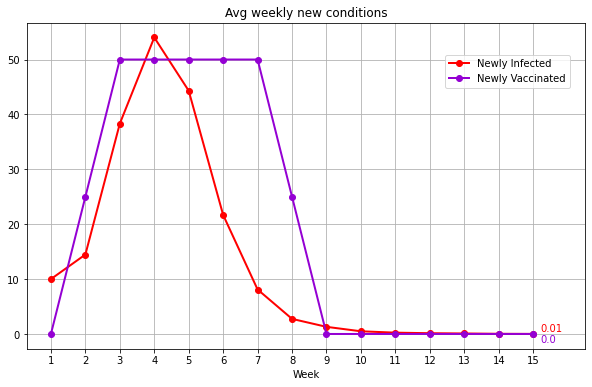

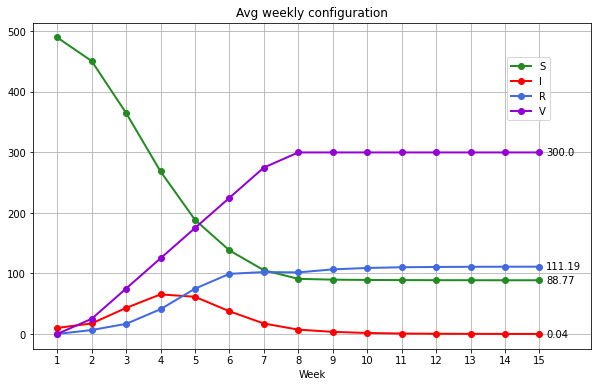

In [ ]:
# PARAMETERS
n = 500
k = 6
a = 0
beta = 0.3  # Infection probability
rho = 0.7  # Recovery probability
n_weeks = 15
n_initial_infected = 10
vaccination = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
n_iter = 100

new_infected_over_time = np.zeros(n_weeks, dtype=int)
susceptible_over_time = np.zeros(n_weeks, dtype=int)
infected_over_time = np.zeros(n_weeks, dtype=int)
recovered_over_time = np.zeros(n_weeks, dtype=int)
vaccinated_over_time = np.zeros(n_weeks, dtype=int)
new_vaccinated_over_time = np.zeros(n_weeks, dtype=int)

# GRAPH CONSTRUCTION
G = Generate_PA_Graph(n, k, a)
W = nx.adjacency_matrix(G)

if n < 32:
  plt.figure(1,figsize=(6,6))
  nx.draw(G, with_labels=True)

# SIMULATION
for iter in range(0,n_iter):

  # Selecting n_initial_infected
  x0 = np.zeros(n, dtype=int)  # initial configuration
  initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
  for infected in initial_infected:
    x0[infected] = 1
  states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

  susceptible_over_time[0] += n - n_initial_infected
  infected_over_time[0] += n_initial_infected
  recovered_over_time[0] += 0
  new_infected_over_time[0] += n_initial_infected
  vaccinated_over_time[0] += 0

  for week in range(1,n_weeks):
    last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
    current_week_config = np.zeros(n, dtype=int)
    new_infected_cnt = 0

    # Vaccination
    n_to_be_vaccinated = int(((vaccination[week] - vaccination[week-1]) / 100) * n)
    nodes_not_yet_vaccinated = np.where(last_week_config != 3)[0]
    nodes_to_be_vaccinated = np.random.choice(nodes_not_yet_vaccinated, size=n_to_be_vaccinated, replace=False)
    for node in nodes_to_be_vaccinated:
      last_week_config[node] = 3
    
    for node in range(0, n):

      if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
        m = np.count_nonzero(np.multiply(W.tocsr()[node].toarray()[0], last_week_config) == 1.0)
        current_week_config[node] = np.random.choice([0, 1], p=[(1-beta)**m, 1-((1-beta)**m)])
        if current_week_config[node] == 1:  # Count newly infected
          new_infected_cnt += 1

      elif last_week_config[node] == 1:  # compute recovery probability
        current_week_config[node] = np.random.choice([1, 2], p=[1-rho, rho])

      else:  # stays recovered or vaccinated
        current_week_config[node] = last_week_config[node]

    states = sp.sparse.vstack([states,current_week_config])
          
    # Counts for visualizations
    susceptible_over_time[week] += np.count_nonzero(current_week_config == 0)
    infected_over_time[week] += np.count_nonzero(current_week_config == 1)
    recovered_over_time[week] += np.count_nonzero(current_week_config == 2)
    vaccinated_over_time[week] += np.count_nonzero(current_week_config == 3)
    new_infected_over_time[week] += new_infected_cnt
    new_vaccinated_over_time[week] += n_to_be_vaccinated

avg_susceptible_over_time = susceptible_over_time / n_iter
avg_infected_over_time = infected_over_time / n_iter
avg_recovered_over_time = recovered_over_time / n_iter
avg_vaccinated_over_time = vaccinated_over_time / n_iter
avg_new_infected_over_time = new_infected_over_time / n_iter
avg_new_vaccinated_over_time = new_vaccinated_over_time / n_iter

time = [i for i in range(1,n_weeks+1)]
fig_1, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_new_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='Newly Infected')
ax.plot(time, avg_new_vaccinated_over_time, c='darkviolet', marker='o', linestyle='-', linewidth=2, label='Newly Vaccinated')
ax.legend(loc=(0.75, 0.8))
ax.set_xlabel('Week')
ax.set_title('Avg weekly new conditions')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_new_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y+0.5, str(y), color='red')
for x, y in enumerate(avg_new_vaccinated_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-1.5, str(y), color='darkviolet')
plt.show()

fig_2, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_susceptible_over_time, c='forestgreen', marker='o', linestyle='-', linewidth=2, label='S')
ax.plot(time, avg_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='I')
ax.plot(time, avg_recovered_over_time, c='royalblue', marker='o', linestyle='-', linewidth=2, label='R')
ax.plot(time, avg_vaccinated_over_time, c='darkviolet', marker='o', linestyle='-', linewidth=2, label='V')
ax.legend(loc=(0.85, 0.70))
ax.set_xlabel('Week')
ax.set_title('Avg weekly configuration')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_susceptible_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_recovered_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_vaccinated_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
plt.show()

if n < 32:
  # Plot the infection spread
  pos = nx.spectral_layout(G)
  fig = plt.figure(figsize=(20,20))
  for t in range(0,n_weeks):
      plt.subplot(3,5,t+1)
      x = np.array(states.tocsr()[t].toarray()[0], dtype=int)
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==0).T[0].tolist(),
          node_color = 'forestgreen')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==1).T[0].tolist(),
          node_color = 'red')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==2).T[0].tolist(),
          node_color = 'royalblue')
      nx.draw_spectral(G,
          with_labels=True,
          nodelist=np.argwhere(x==3).T[0].tolist(),
          node_color = 'darkviolet')
      plt.title('Week = {0}'.format(t+1))

##PROBLEM 4

In [ ]:
def rmse(real, simulated):
  return np.sqrt(np.mean(np.power(np.subtract(simulated, real), 2)))

def mse(real, simulated):
  return np.mean(np.power(np.subtract(simulated, real), 2))

In [ ]:
n = 934
a = 0
n_weeks = 15
n_initial_infected = 1
n_iter = 10

vaccination = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
real_new_infected_over_time = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0])

flag = 0
best_error = float('inf')
best_config = {}
best_error_hystory = [100000]
index = 0
tried_configs = []  # Avoid computing twice

while True:

  if index == 0:
    k_0 = 6
    beta_0 = 0.3
    rho_0 = 0.6
    D_k = 1
    D_beta = 0.1
    D_rho = 0.1
  else:
    k_0 = best_config['k']
    beta_0 = best_config['beta']
    rho_0 = best_config['rho']

  print('\n', f"Now running config: K = {k_0}, beta_0 = {beta_0}, rho_0 = {rho_0}, D_k = {D_k}, D_beta = {D_beta}, D_rho = {D_rho}" '\n')

  parameters = {
                "k": [k_0 - D_k, k_0, k_0 + D_k],
                "beta": [round(beta_0 - D_beta, 3), beta_0, beta_0 + D_beta],
                "rho": [round(rho_0 - D_rho, 3), rho_0, rho_0 + D_rho],
                "D_k": [D_k],
                "D_beta": [D_beta],
                "D_rho": [D_rho]
                }

  for config in ParameterGrid(parameters):

    if config['k'] < 0:
      config['k'] = 0
    if config['beta'] < 0:
      continue
    if config['rho'] < 0:
      config['rho'] = 0

    if config in tried_configs:
      print(f"Simulation Parameters: {config} - Already Computed")
      continue
    else:
      tried_configs.append(config)

    # GRAPH CONSTRUCTION
    G = Generate_PA_Graph(n, config['k'], a)
    W = nx.adjacency_matrix(G)

    simulated_new_infected_over_time = np.zeros(n_weeks, dtype=int)

    # SIMULATION
    for iter in range(0,n_iter):

      # Selecting n_initial_infected
      x0 = np.zeros(n, dtype=int)  # initial configuration
      initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
      for infected in initial_infected:
        x0[infected] = 1
      states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

      simulated_new_infected_over_time[0] += n_initial_infected

      for week in range(1,n_weeks):
        last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
        current_week_config = np.zeros(n, dtype=int)
        new_infected_cnt = 0

        # Vaccination
        n_to_be_vaccinated = int(((vaccination[week] - vaccination[week-1]) / 100) * n)
        nodes_not_yet_vaccinated = np.where(last_week_config != 3)[0]
        nodes_to_be_vaccinated = np.random.choice(nodes_not_yet_vaccinated, size=n_to_be_vaccinated, replace=False)
        for node in nodes_to_be_vaccinated:
          last_week_config[node] = 3
        
        for node in range(0, n):

          if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
            m = np.count_nonzero(np.multiply(W.tocsr()[node].toarray()[0], last_week_config) == 1.0)
            current_week_config[node] = np.random.choice([0, 1], p=[(1-config['beta'])**m, 1-((1-config['beta'])**m)])
            if current_week_config[node] == 1:  # Count newly infected
              new_infected_cnt += 1

          elif last_week_config[node] == 1:  # compute recovery probability
            current_week_config[node] = np.random.choice([1, 2], p=[1-config['rho'], config['rho']])

          else:  # stays recovered or vaccinated
            current_week_config[node] = last_week_config[node]

        states = sp.sparse.vstack([states,current_week_config])
              
        simulated_new_infected_over_time[week] += new_infected_cnt

    avg_simulated_new_infected_over_time = simulated_new_infected_over_time / n_iter
    error = rmse(real_new_infected_over_time, avg_simulated_new_infected_over_time)

    if error < best_error:
      best_error = error
      best_config = config

    print(f"Simulation Parameters: {config} - RMSE: {round(error, 3)}")
  
  if best_error >= best_error_hystory[index]:
    if flag == 0:
      print('\n', f"No improvement. Decreasing Deltas", '\n')
      flag = 1
      D_beta = D_beta / 2
      D_rho = D_rho / 2
    else:
      break  # breaks only if there is no improvement for two times in a row
  else:
    best_error_hystory.append(best_error)
    index += 1
    flag = 0
    print('\n', f"Best Config: {best_config} - Error: {best_error}")


 Now running config: K = 6, beta_0 = 0.3, rho_0 = 0.6, D_k = 1, D_beta = 0.1, D_rho = 0.1

Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 5, 'rho': 0.5} - RMSE: 11.223
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 5, 'rho': 0.6} - RMSE: 8.114
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 5, 'rho': 0.7} - RMSE: 10.868
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 6, 'rho': 0.5} - RMSE: 6.477
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 6, 'rho': 0.6} - RMSE: 12.172
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 6, 'rho': 0.7} - RMSE: 11.391
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 7, 'rho': 0.5} - RMSE: 6.343
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 7, 'rho': 0.6} - RMSE: 8.266
Simulation Parameters: {

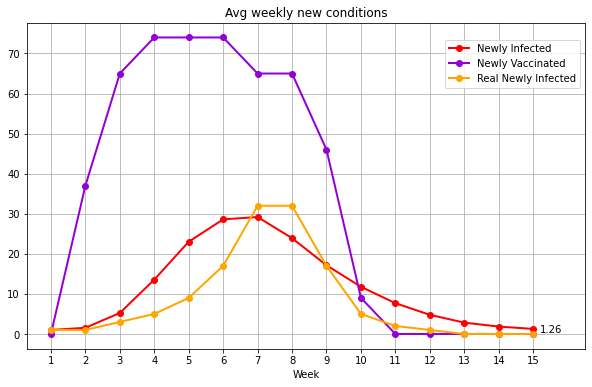

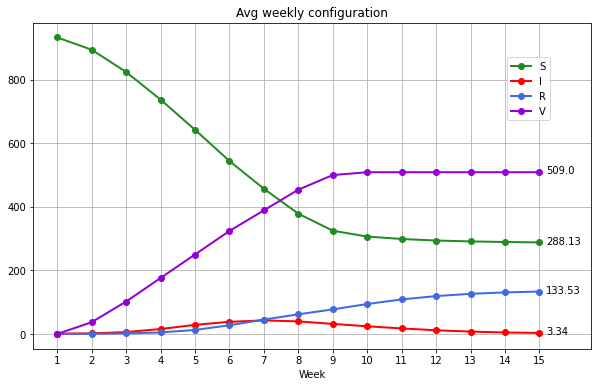

In [ ]:
"""
Good configurations:
k=6, beta=0.3, rho=0.6
k=11, beta=0.15, rho=0.6
k=5, beta=0.4, rho=0.7
"""

# PARAMETERS
n = 934
k = 6
a = 0
beta = 0.3  # Infection probability
rho = 0.6  # Recovery probability

n_weeks = 15
n_initial_infected = 1
vaccination = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
real_new_infected_over_time = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0])
n_iter = 100

new_infected_over_time = np.zeros(n_weeks, dtype=int)
susceptible_over_time = np.zeros(n_weeks, dtype=int)
infected_over_time = np.zeros(n_weeks, dtype=int)
recovered_over_time = np.zeros(n_weeks, dtype=int)
vaccinated_over_time = np.zeros(n_weeks, dtype=int)
new_vaccinated_over_time = np.zeros(n_weeks, dtype=int)

# GRAPH CONSTRUCTION
G = Generate_PA_Graph(n, k, a)
W = nx.adjacency_matrix(G)

# SIMULATION
for iter in range(0,n_iter):

  # Selecting n_initial_infected
  x0 = np.zeros(n, dtype=int)  # initial configuration
  initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
  for infected in initial_infected:
    x0[infected] = 1
  states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

  susceptible_over_time[0] += n - n_initial_infected
  infected_over_time[0] += n_initial_infected
  recovered_over_time[0] += 0
  new_infected_over_time[0] += n_initial_infected
  vaccinated_over_time[0] += 0

  for week in range(1,n_weeks):
    last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
    current_week_config = np.zeros(n, dtype=int)
    new_infected_cnt = 0

    # Vaccination
    n_to_be_vaccinated = int(((vaccination[week] - vaccination[week-1]) / 100) * n)
    nodes_not_yet_vaccinated = np.where(last_week_config != 3)[0]
    nodes_to_be_vaccinated = np.random.choice(nodes_not_yet_vaccinated, size=n_to_be_vaccinated, replace=False)
    for node in nodes_to_be_vaccinated:
      last_week_config[node] = 3
    
    for node in range(0, n):

      if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
        m = np.count_nonzero(np.multiply(W.tocsr()[node].toarray()[0], last_week_config) == 1.0)
        current_week_config[node] = np.random.choice([0, 1], p=[(1-beta)**m, 1-((1-beta)**m)])
        if current_week_config[node] == 1:  # Count newly infected
          new_infected_cnt += 1

      elif last_week_config[node] == 1:  # compute recovery probability
        current_week_config[node] = np.random.choice([1, 2], p=[1-rho, rho])

      else:  # stays recovered or vaccinated
        current_week_config[node] = last_week_config[node]

    states = sp.sparse.vstack([states,current_week_config])
          
    # Counts for visualizations
    susceptible_over_time[week] += np.count_nonzero(current_week_config == 0)
    infected_over_time[week] += np.count_nonzero(current_week_config == 1)
    recovered_over_time[week] += np.count_nonzero(current_week_config == 2)
    vaccinated_over_time[week] += np.count_nonzero(current_week_config == 3)
    new_infected_over_time[week] += new_infected_cnt
    new_vaccinated_over_time[week] += n_to_be_vaccinated

avg_susceptible_over_time = susceptible_over_time / n_iter
avg_infected_over_time = infected_over_time / n_iter
avg_recovered_over_time = recovered_over_time / n_iter
avg_vaccinated_over_time = vaccinated_over_time / n_iter
avg_new_infected_over_time = new_infected_over_time / n_iter
avg_new_vaccinated_over_time = new_vaccinated_over_time / n_iter

time = [i for i in range(1,n_weeks+1)]
fig_1, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_new_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='Newly Infected')
ax.plot(time, avg_new_vaccinated_over_time, c='darkviolet', marker='o', linestyle='-', linewidth=2, label='Newly Vaccinated')
ax.plot(time, real_new_infected_over_time, c='orange', marker='o', linestyle='-', linewidth=2, label='Real Newly Infected')
ax.legend(loc=(0.75, 0.8))
ax.set_xlabel('Week')
ax.set_title('Avg weekly new conditions')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_new_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-1, str(y), color='k')
plt.show()

fig_2, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_susceptible_over_time, c='forestgreen', marker='o', linestyle='-', linewidth=2, label='S')
ax.plot(time, avg_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='I')
ax.plot(time, avg_recovered_over_time, c='royalblue', marker='o', linestyle='-', linewidth=2, label='R')
ax.plot(time, avg_vaccinated_over_time, c='darkviolet', marker='o', linestyle='-', linewidth=2, label='V')
ax.legend(loc=(0.85, 0.70))
ax.set_xlabel('Week')
ax.set_title('Avg weekly configuration')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_susceptible_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_recovered_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_vaccinated_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
plt.show()

In [ ]:
print(rmse(real_new_infected_over_time, avg_new_infected_over_time))

6.264227007380879


##PROBLEM 5

In [ ]:
# ERDOS RENYI

def Generate_ER_Graph(total_nodes, avg_degree):

  G = nx.Graph()
  p = avg_degree / (total_nodes-1)

  for node_1 in range(0, total_nodes):
    for node_2 in range(0, total_nodes):
      if node_1 != node_2 and (np.random.choice([0, 1], p=[1-p,p])) == 1:
        G.add_edge(node_1,node_2)  # Edges creation

  G.add_nodes_from([i for i in range(0, total_nodes)])
      
  return G

  def rmse(real, simulated):
    return np.sqrt(np.mean(np.power(np.subtract(simulated, real), 2)))

In [ ]:
n = 934
n_weeks = 15
n_initial_infected = 1
n_iter = 10

vaccination = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
real_new_infected_over_time = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0])

flag = 0
best_error = float('inf')
best_config = {}
best_error_hystory = [100000]
index = 0
tried_configs = []

while True:

  if index == 0:
    k_0 = 6
    beta_0 = 0.3
    rho_0 = 0.6
    D_k = 1
    D_beta = 0.1
    D_rho = 0.1
  else:
    k_0 = best_config['k']
    beta_0 = best_config['beta']
    rho_0 = best_config['rho']

  print('\n', f"Now running config: K = {k_0}, beta_0 = {beta_0}, rho_0 = {rho_0}, D_k = {D_k}, D_beta = {D_beta}, D_rho = {D_rho}" '\n')

  parameters = {
                "k": [k_0 - D_k, k_0, k_0 + D_k],
                "beta": [round(beta_0 - D_beta, 3), beta_0, round(beta_0 + D_beta, 3)],
                "rho": [round(rho_0 - D_rho, 3), rho_0, round(rho_0 + D_rho, 3)],
                "D_k": [D_k],
                "D_beta": [D_beta],
                "D_rho": [D_rho]
                }

  for config in ParameterGrid(parameters):

    if config['k'] < 0:
      config['k'] = 0
    if config['beta'] < 0:
      continue
    if config['rho'] < 0:
      config['rho'] = 0

    if config in tried_configs:
      print(f"Simulation Parameters: {config} - Already Computed")
      continue
    else:
      tried_configs.append(config)

    # GRAPH CONSTRUCTION
    G = Generate_ER_Graph(n, config['k'])
    W = nx.adjacency_matrix(G)

    simulated_new_infected_over_time = np.zeros(n_weeks, dtype=int)

    # SIMULATION
    for iter in range(0,n_iter):

      # Selecting n_initial_infected
      x0 = np.zeros(n, dtype=int)  # initial configuration
      initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
      for infected in initial_infected:
        x0[infected] = 1
      states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

      simulated_new_infected_over_time[0] += n_initial_infected

      for week in range(1,n_weeks):
        last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
        current_week_config = np.zeros(n, dtype=int)
        new_infected_cnt = 0

        # Vaccination
        n_to_be_vaccinated = int(((vaccination[week] - vaccination[week-1]) / 100) * n)
        nodes_not_yet_vaccinated = np.where(last_week_config != 3)[0]
        nodes_to_be_vaccinated = np.random.choice(nodes_not_yet_vaccinated, size=n_to_be_vaccinated, replace=False)
        for node in nodes_to_be_vaccinated:
          last_week_config[node] = 3
        
        for node in range(0, n):

          if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
            m = np.count_nonzero(np.multiply(W.tocsr()[node].toarray()[0], last_week_config) == 1.0)
            current_week_config[node] = np.random.choice([0, 1], p=[(1-config['beta'])**m, 1-((1-config['beta'])**m)])
            if current_week_config[node] == 1:  # Count newly infected
              new_infected_cnt += 1

          elif last_week_config[node] == 1:  # compute recovery probability
            current_week_config[node] = np.random.choice([1, 2], p=[1-config['rho'], config['rho']])

          else:  # stays recovered or vaccinated
            current_week_config[node] = last_week_config[node]

        states = sp.sparse.vstack([states,current_week_config])
              
        simulated_new_infected_over_time[week] += new_infected_cnt

    avg_simulated_new_infected_over_time = simulated_new_infected_over_time / n_iter
    error = rmse(real_new_infected_over_time, avg_simulated_new_infected_over_time)

    if error < best_error:
      best_error = error
      best_config = config

    print(f"Simulation Parameters: {config} - RMSE: {round(error, 3)}")
  
  if best_error >= best_error_hystory[index]:
    if flag == 0:
      print('\n', f"No improvement. Decreasing Deltas", '\n')
      flag = 1
      D_beta = D_beta / 2
      D_rho = D_rho / 2
    else:
      break  # breaks only if there is no improvement for two times in a row
  else:
    best_error_hystory.append(best_error)
    index += 1
    flag = 0
    print('\n', f"Best Config: {best_config} - Error: {best_error}")


 Now running config: K = 6, beta_0 = 0.3, rho_0 = 0.6, D_k = 1, D_beta = 0.1, D_rho = 0.1

Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 5, 'rho': 0.5} - RMSE: 8.514
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 5, 'rho': 0.6} - RMSE: 8.475
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 5, 'rho': 0.7} - RMSE: 7.769
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 6, 'rho': 0.5} - RMSE: 17.0
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 6, 'rho': 0.6} - RMSE: 6.599
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 6, 'rho': 0.7} - RMSE: 9.65
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 7, 'rho': 0.5} - RMSE: 24.513
Simulation Parameters: {'D_beta': 0.1, 'D_k': 1, 'D_rho': 0.1, 'beta': 0.2, 'k': 7, 'rho': 0.6} - RMSE: 17.999
Simulation Parameters: {'D_b

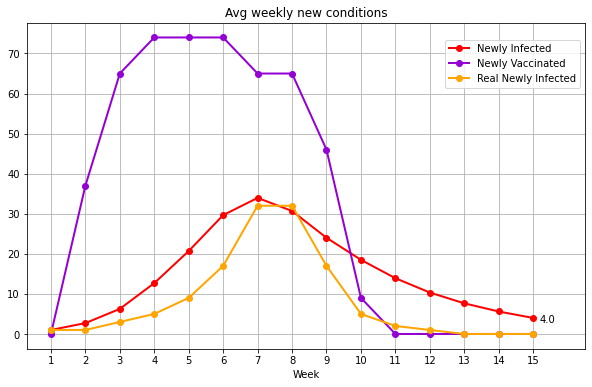

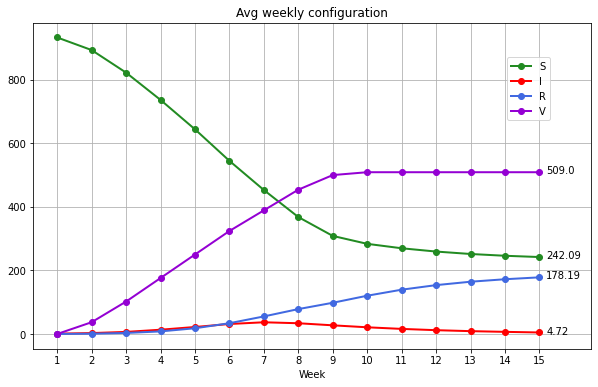

In [ ]:
"""
Good configurations:
k=13, beta=0.1, rho=0.9
k=6, beta=0.2, rho=0.6
"""

# PARAMETERS
n = 934
k = 13
beta = 0.1  # Infection probability
rho = 0.9  # Recovery probability

n_weeks = 15
n_initial_infected = 1
vaccination = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60]
real_new_infected_over_time = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0])
n_iter = 100

new_infected_over_time = np.zeros(n_weeks, dtype=int)
susceptible_over_time = np.zeros(n_weeks, dtype=int)
infected_over_time = np.zeros(n_weeks, dtype=int)
recovered_over_time = np.zeros(n_weeks, dtype=int)
vaccinated_over_time = np.zeros(n_weeks, dtype=int)
new_vaccinated_over_time = np.zeros(n_weeks, dtype=int)

# GRAPH CONSTRUCTION
G = Generate_ER_Graph(n, k)
W = nx.adjacency_matrix(G)

# SIMULATION
for iter in range(0,n_iter):

  # Selecting n_initial_infected
  x0 = np.zeros(n, dtype=int)  # initial configuration
  initial_infected = np.random.choice([i for i in range(0,n)], n_initial_infected, replace=False)
  for infected in initial_infected:
    x0[infected] = 1
  states = sp.sparse.lil_matrix(x0)  # insertion in configuration matrix

  susceptible_over_time[0] += n - n_initial_infected
  infected_over_time[0] += n_initial_infected
  recovered_over_time[0] += 0
  new_infected_over_time[0] += n_initial_infected
  vaccinated_over_time[0] += 0

  for week in range(1,n_weeks):
    last_week_config = np.array(states.tocsr()[week-1].toarray()[0], dtype=int)
    current_week_config = np.zeros(n, dtype=int)
    new_infected_cnt = 0

    # Vaccination
    n_to_be_vaccinated = int(((vaccination[week] - vaccination[week-1]) / 100) * n)
    nodes_not_yet_vaccinated = np.where(last_week_config != 3)[0]
    nodes_to_be_vaccinated = np.random.choice(nodes_not_yet_vaccinated, size=n_to_be_vaccinated, replace=False)
    for node in nodes_to_be_vaccinated:
      last_week_config[node] = 3
    
    for node in range(0, n):

      if last_week_config[node] == 0:  # count infected neighbours and compute infection probability
        m = np.count_nonzero(np.multiply(W.tocsr()[node].toarray()[0], last_week_config) == 1.0)
        current_week_config[node] = np.random.choice([0, 1], p=[(1-beta)**m, 1-((1-beta)**m)])
        if current_week_config[node] == 1:  # Count newly infected
          new_infected_cnt += 1

      elif last_week_config[node] == 1:  # compute recovery probability
        current_week_config[node] = np.random.choice([1, 2], p=[1-rho, rho])

      else:  # stays recovered or vaccinated
        current_week_config[node] = last_week_config[node]

    states = sp.sparse.vstack([states,current_week_config])
          
    # Counts for visualizations
    susceptible_over_time[week] += np.count_nonzero(current_week_config == 0)
    infected_over_time[week] += np.count_nonzero(current_week_config == 1)
    recovered_over_time[week] += np.count_nonzero(current_week_config == 2)
    vaccinated_over_time[week] += np.count_nonzero(current_week_config == 3)
    new_infected_over_time[week] += new_infected_cnt
    new_vaccinated_over_time[week] += n_to_be_vaccinated

avg_susceptible_over_time = susceptible_over_time / n_iter
avg_infected_over_time = infected_over_time / n_iter
avg_recovered_over_time = recovered_over_time / n_iter
avg_vaccinated_over_time = vaccinated_over_time / n_iter
avg_new_infected_over_time = new_infected_over_time / n_iter
avg_new_vaccinated_over_time = new_vaccinated_over_time / n_iter

time = [i for i in range(1,n_weeks+1)]
fig_1, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_new_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='Newly Infected')
ax.plot(time, avg_new_vaccinated_over_time, c='darkviolet', marker='o', linestyle='-', linewidth=2, label='Newly Vaccinated')
ax.plot(time, real_new_infected_over_time, c='orange', marker='o', linestyle='-', linewidth=2, label='Real Newly Infected')
ax.legend(loc=(0.75, 0.8))
ax.set_xlabel('Week')
ax.set_title('Avg weekly new conditions')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_new_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-1, str(y), color='k')
plt.show()

fig_2, ax = plt.subplots(figsize=(10, 6))
ax.plot(time, avg_susceptible_over_time, c='forestgreen', marker='o', linestyle='-', linewidth=2, label='S')
ax.plot(time, avg_infected_over_time, c='red', marker='o', linestyle='-', linewidth=2, label='I')
ax.plot(time, avg_recovered_over_time, c='royalblue', marker='o', linestyle='-', linewidth=2, label='R')
ax.plot(time, avg_vaccinated_over_time, c='darkviolet', marker='o', linestyle='-', linewidth=2, label='V')
ax.legend(loc=(0.85, 0.70))
ax.set_xlabel('Week')
ax.set_title('Avg weekly configuration')
ax.grid('on')
plt.xticks(ticks=[i for i in range(1, n_weeks+1)])
ax.set_xlim(left=None, right=16.5)
for x, y in enumerate(avg_susceptible_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_infected_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_recovered_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
for x, y in enumerate(avg_vaccinated_over_time):
  if x == n_weeks - 1:
    ax.text(x+1.2, y-5, str(y), color='k')
plt.show()